In [1]:
import numpy as np
from tools import *
from projectors import *
import seaborn as sns; sns.set_theme()
from matplotlib.pyplot import figure
sns.set(rc={'figure.figsize':(14,6)})
%load_ext autoreload
%autoreload 2

In [2]:


def train_test_method(X, Y, model, reg=0, train_test_ratio=0.2, dim=100, plot=False, name=''):

    split = int(len(X) * train_test_ratio)
    X_train, X_test = X[split:], X[:split]
    Y_train, Y_test = Y[split:], Y[:split]

    P_train, theta = model(X_train, Y_train, dim, reg=reg)

    pad_test_sig = np.concatenate([np.zeros(dim - 1), X_test])
    test_Han = build_hankel(pad_test_sig, dim)
    P_test = theta @ test_Han 
    P_test = normalize(P_test)

    train_err = mean_square_error(Y_train, P_train)
    test_err = mean_square_error(Y_test, P_test)

    if plot:
        figure(figsize = (8, 8), dpi = 80)
        plt.plot(theta)
        plt.title(f"{name} Fit Eigenvectors")
        plt.show()

        plt.plot(Y_train, label="True");
        plt.plot(P_train, label="Pred");
        plt.title(f"{name} TRAIN Fit Sig"); plt.legend()
        plt.show()

        plt.plot(Y_test, label="True")
        plt.plot(P_test, label="Pred")
        plt.title(f"{name} TEST Fit Sig"); plt.legend()
        plt.show()

        print(f'Train Error: {train_err}')
        print(f'Test Error: {test_err}')

    return train_err, test_err, theta


class Results:
    def __init__(self, model, name):
        self.model = model
        self.name = name
        self.train_errs = []
        self.test_errs = []
        self.filters = []
        self.X = []

    def add_results(self, x, res):
        train_err, test_err, theta = res 
        self.train_errs.append(train_err)
        
        self.test_errs.append(test_err)
        self.filters.append(theta)
        self.X.append(x)

    def get_test_opt(self):
        min_i = np.argmin(self.test_errs)
        return self.X[min_i], self.filters[min_i]


    def plot_eigs(self, step=1):
        for i,e in list(enumerate(self.filters))[::step]:
            figure(figsize = (6, 6), dpi = 80)
            plt.plot(e)
            plt.title(f'{self.name} Reg={self.X[i]}')
            plt.show()


In [60]:
from tools import *
from projectors import *

def do_full_experiment(dataset, dim, train_test_ratio=0.2, downsample=10, regs=np.arange(0,25,1), sig_scalar=1, plot_sig=False, plot_eigs=False, plot_train=True, plot_test=True, plot_opt=True):

    ressP, stimsP = read_lmc('PHOTO');
    ress, stims = read_lmc(dataset);
    sig = normalize(np.mean(ressP[:, ::downsample], axis=0)) * sig_scalar
    res = normalize(np.mean(ress[:, ::downsample], axis=0)) 

    # noise = 2
    # sig += noise * np.random.randn(*sig.shape)

    # baseline
    ones_train_err, ones_test_err, _ = train_test_method(sig, res, ones_model, dim=dim, train_test_ratio=train_test_ratio, plot=False)

    # run tests
    all_results = [Results(linear_model, f'{dataset} Linear'), Results(eigen_proj, f'{dataset} Ridge-EigenProj')] #, Results(eigen_proj_low_rank, f'{dataset} LowRank-EigenProj')

    for reg in regs:
        for results in all_results:
            r = train_test_method(sig, res, results.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=False)
            results.add_results(reg, r)

    if plot_sig:
        plt.plot(sig);
        plt.title("Input Signal")
        plt.show();
    if plot_test:
        for result in all_results:
            plt.plot(regs, result.test_errs, label=f'{result.name} Error')

        plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
        plt.xlabel('Regularization'); plt.ylabel('Error');
        plt.legend(); plt.title("{dataset} Regularization vs Test Error"); plt.show();

    if plot_train:
        for result in all_results:
            plt.plot(regs, result.train_errs, label=f'{result.name} Error')

        plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
        plt.xlabel('Regularization'); plt.ylabel('Error');
        plt.legend(); plt.title("{dataset} Regularization vs Train Error"); plt.show();

    for result in all_results:
        if plot_opt:
            reg, filt = result.get_test_opt()
            train_test_method(sig, res, result.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=True, name=result.name)
        if plot_eigs:
            result.plot_eigs(step=1)


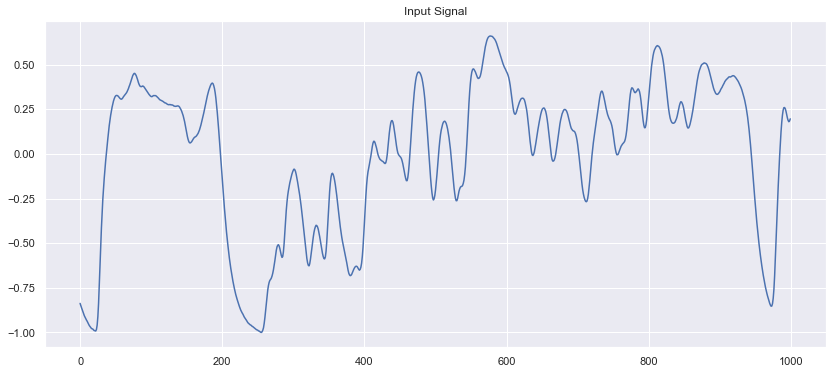

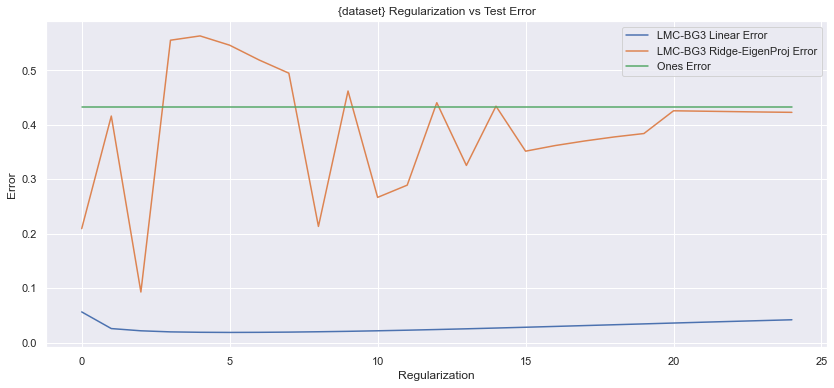

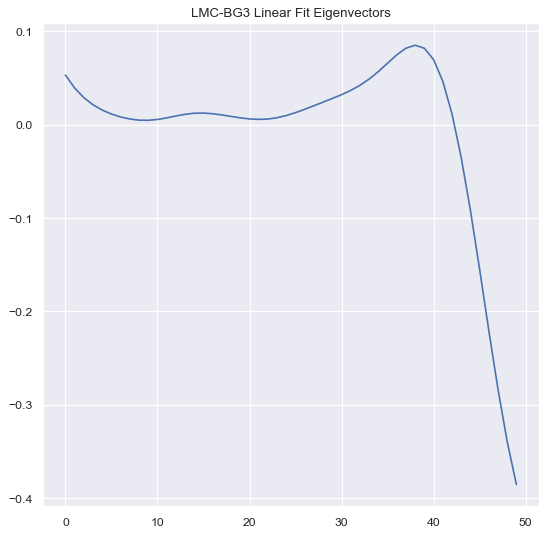

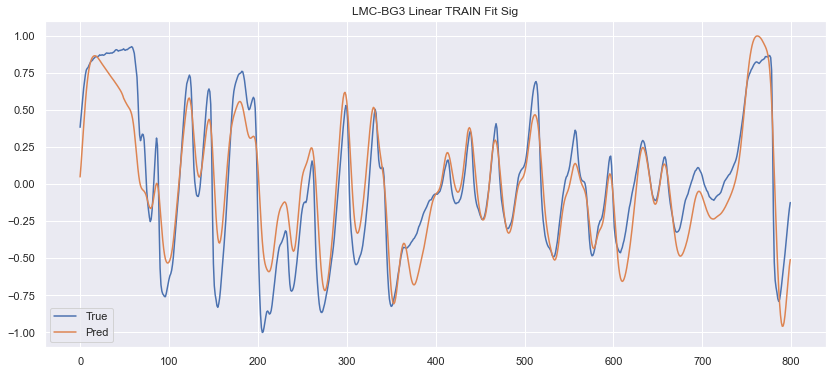

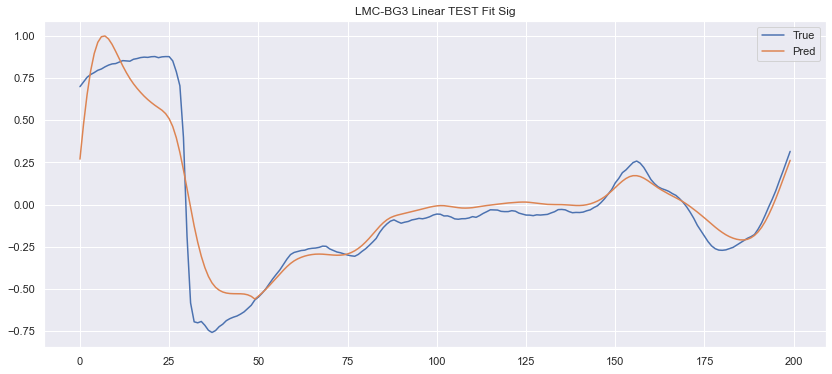

Train Error: 0.04171738967968887
Test Error: 0.018948996634125078


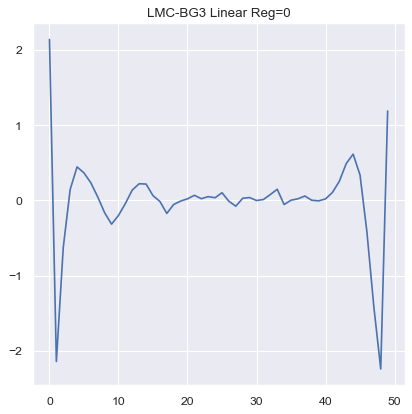

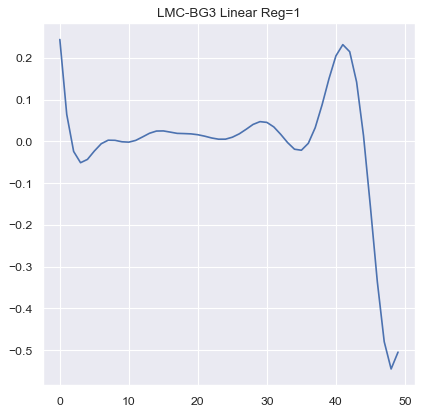

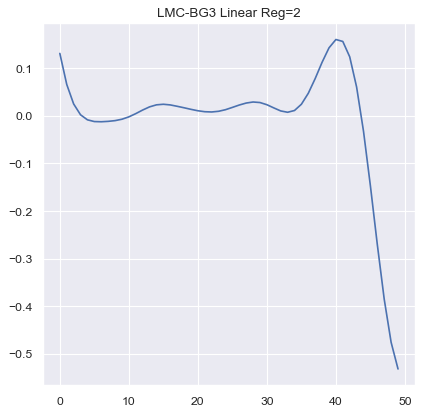

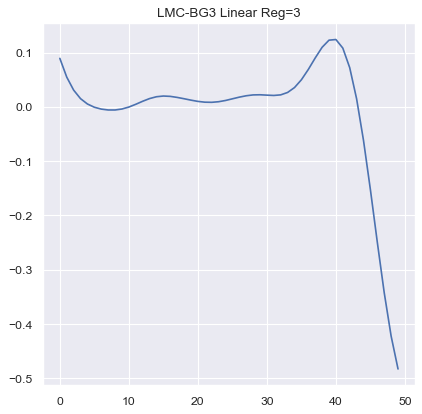

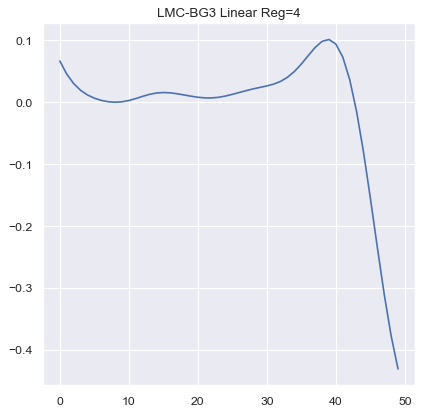

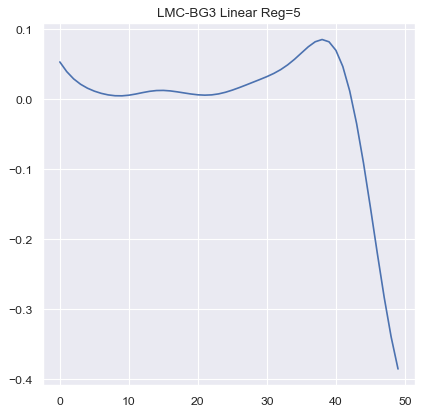

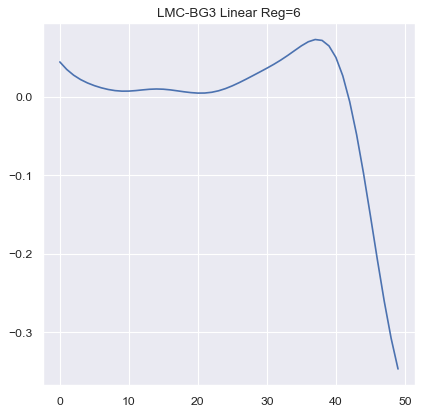

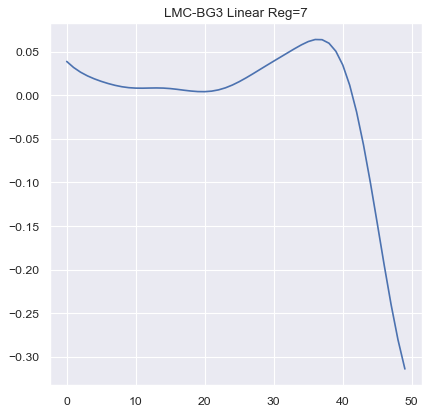

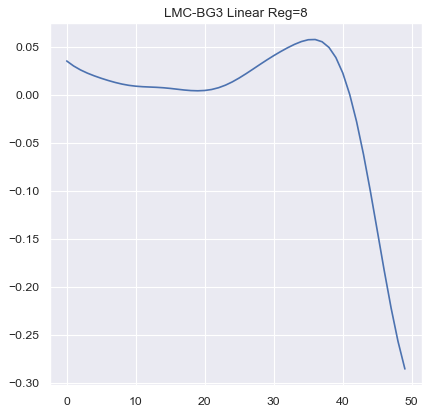

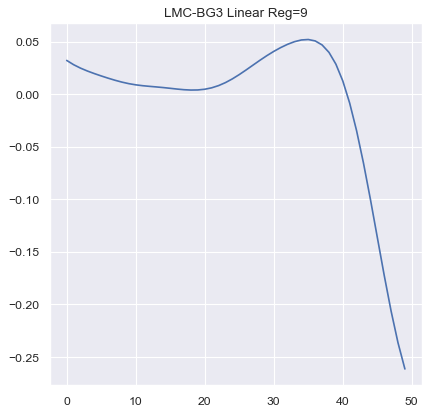

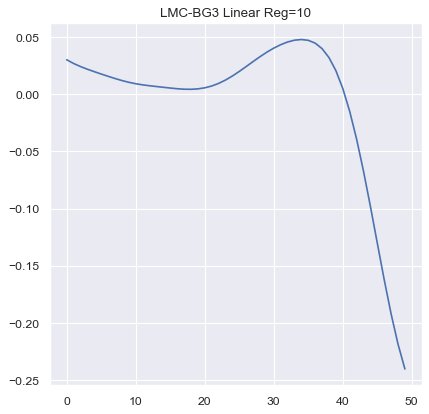

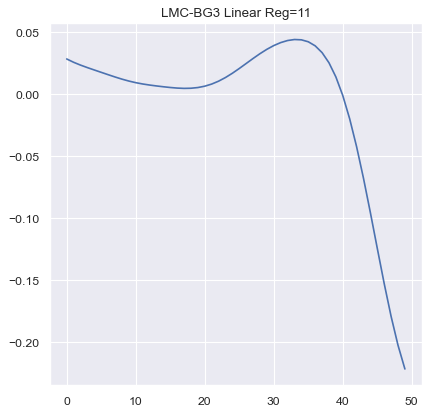

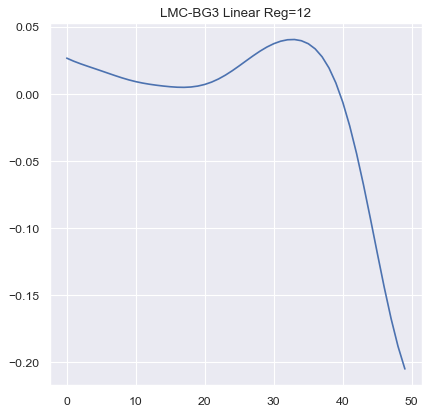

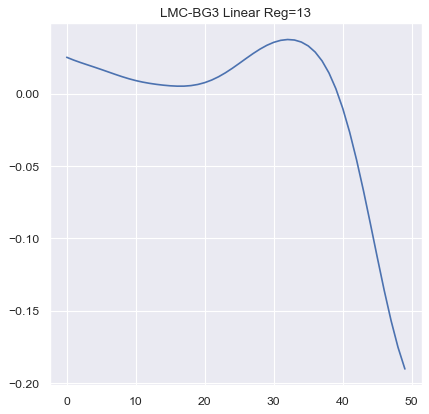

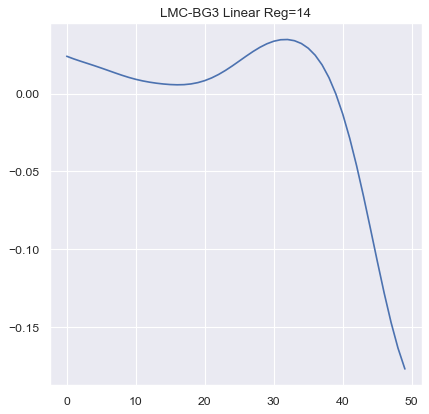

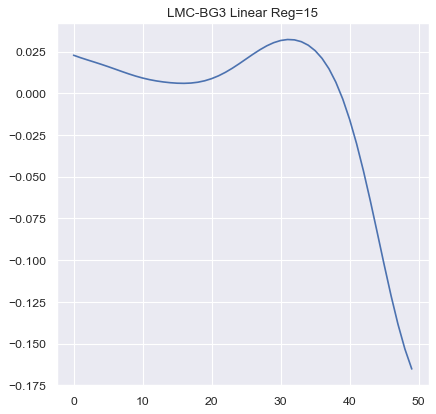

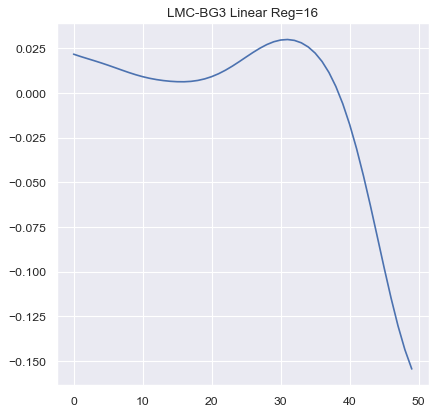

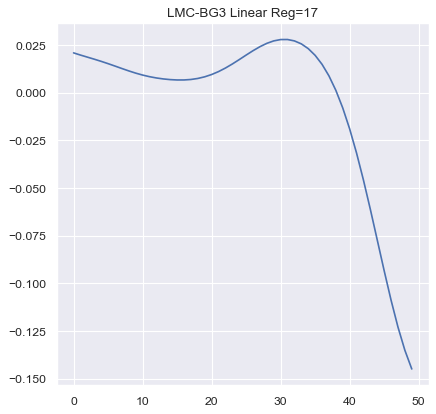

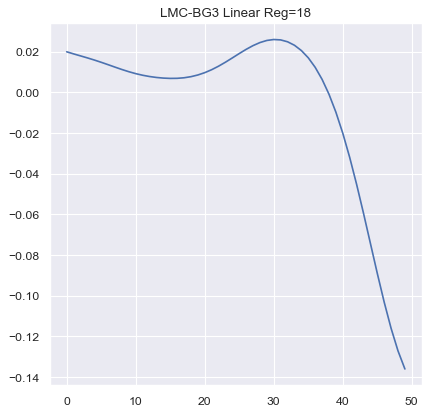

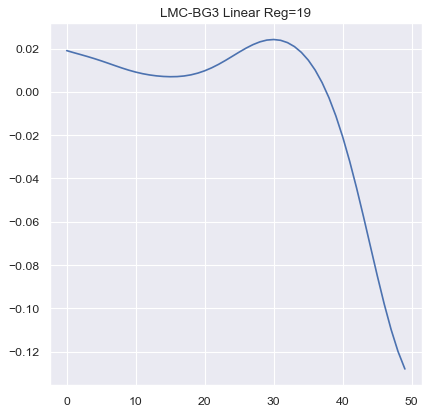

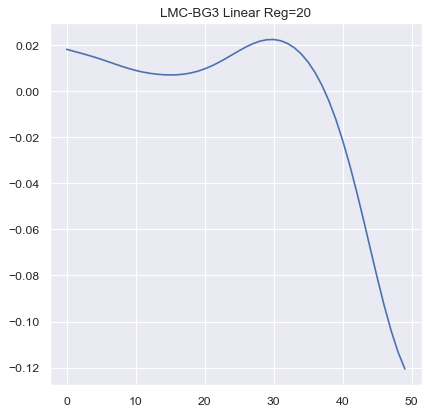

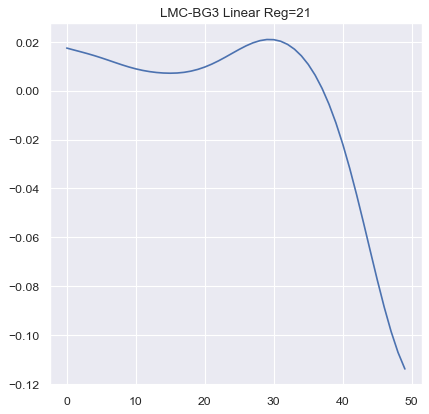

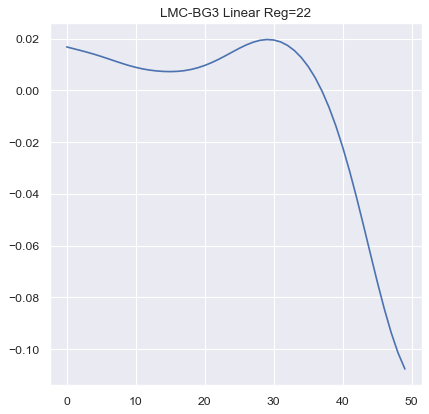

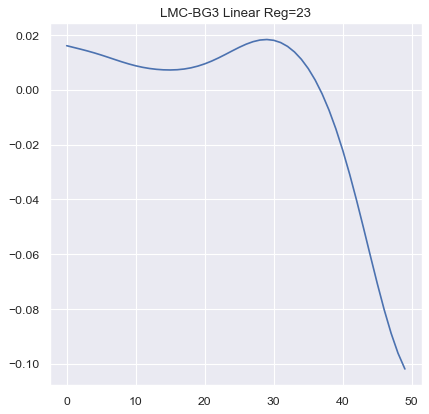

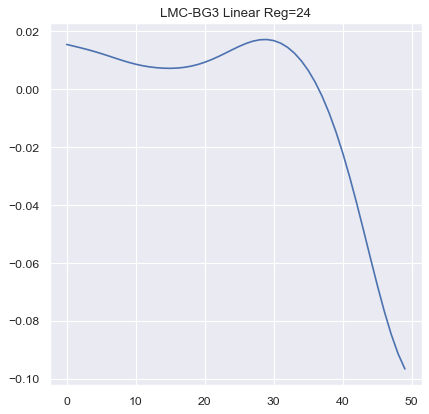

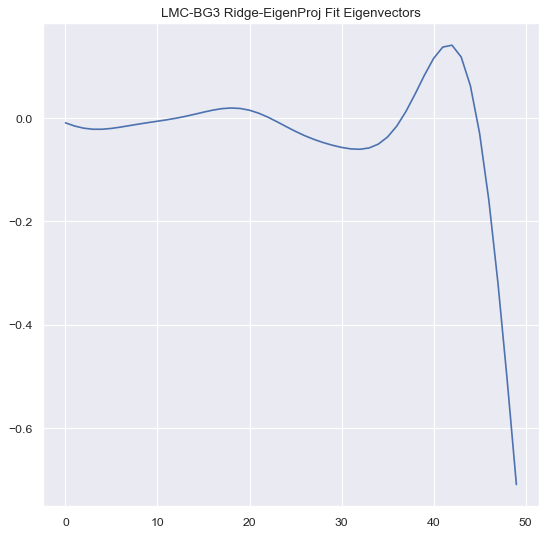

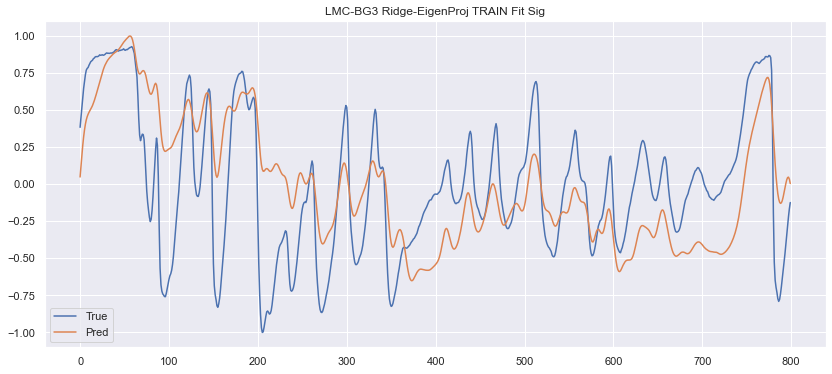

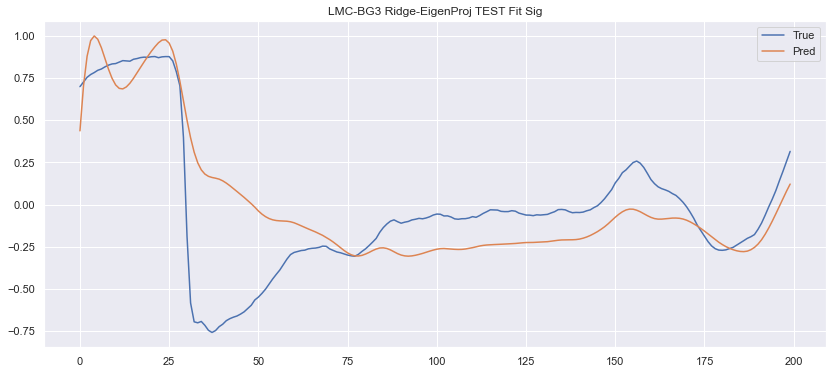

Train Error: 0.1591107770796311
Test Error: 0.0931310112186114


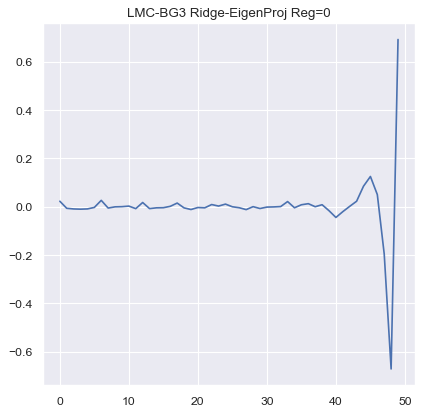

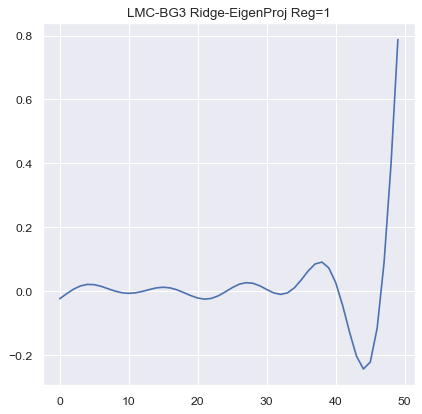

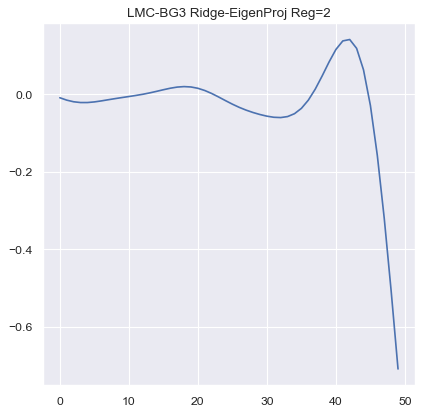

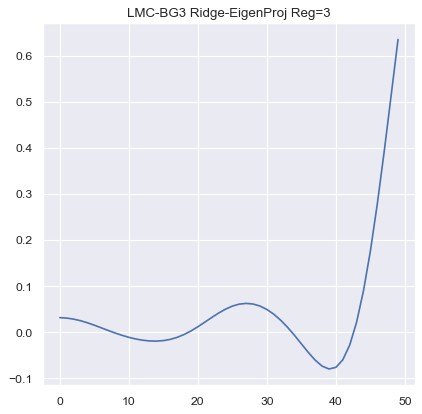

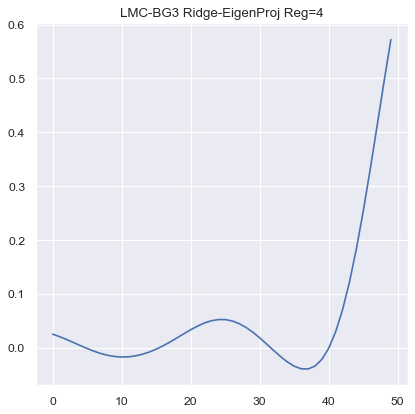

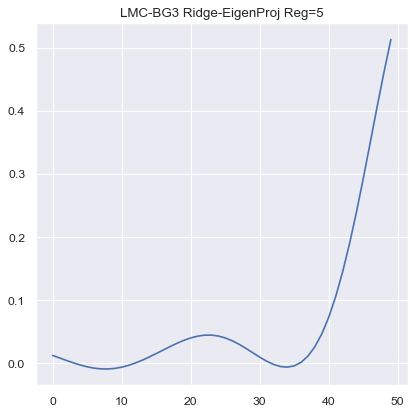

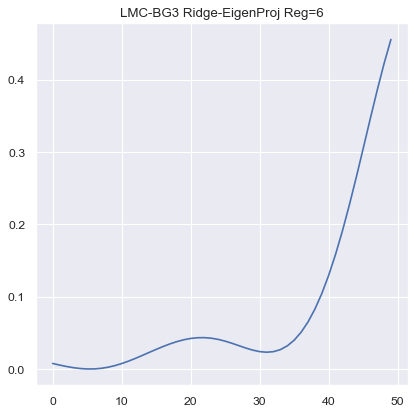

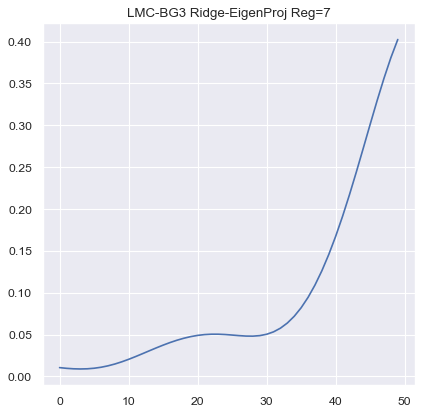

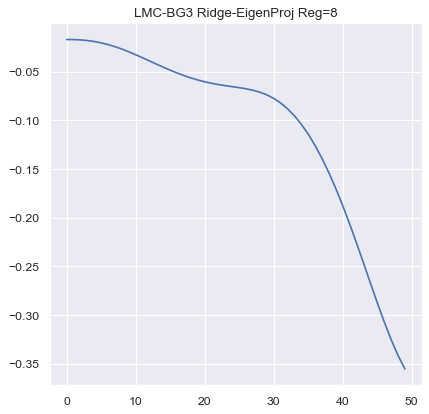

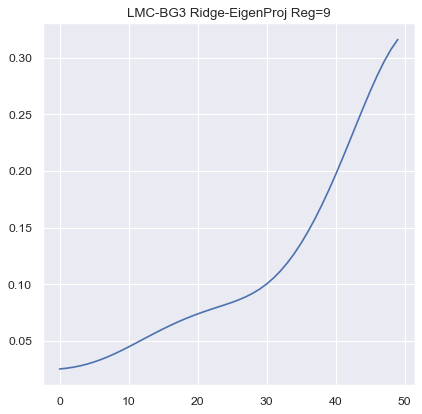

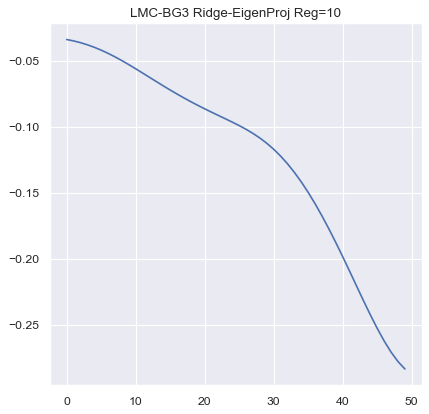

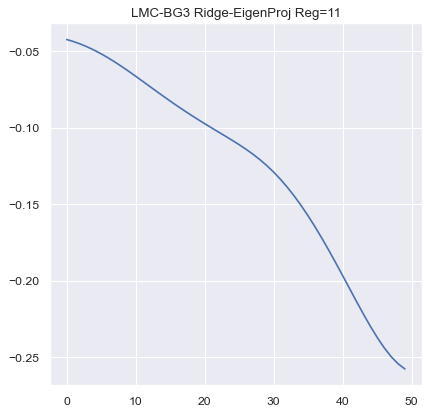

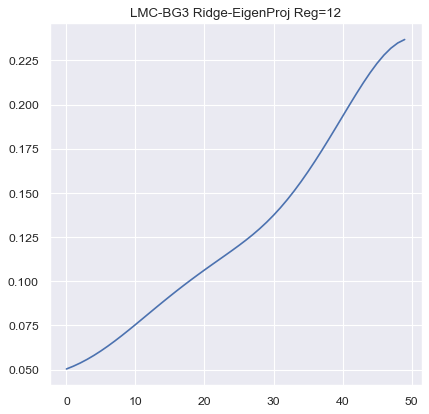

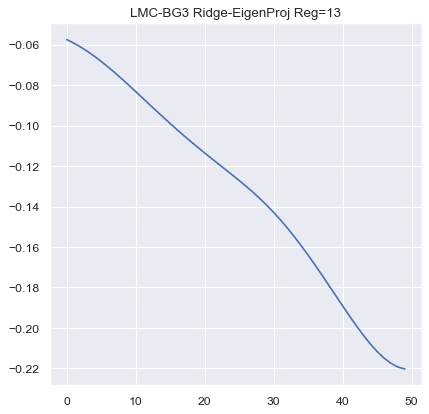

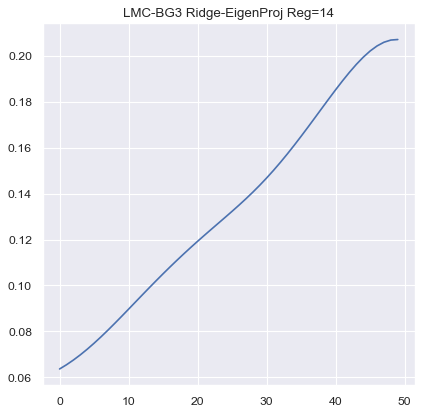

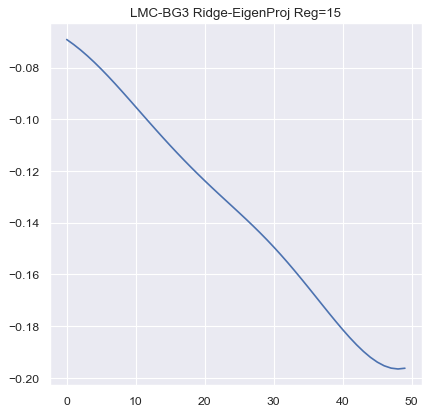

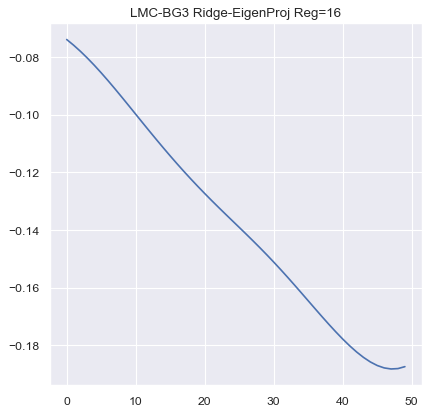

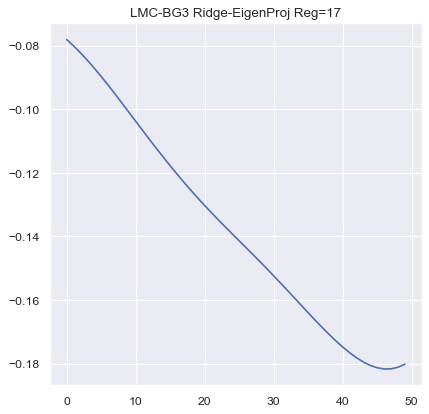

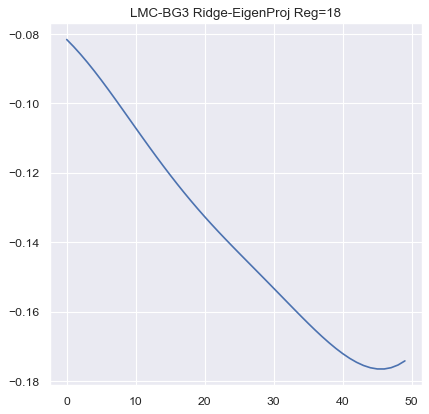

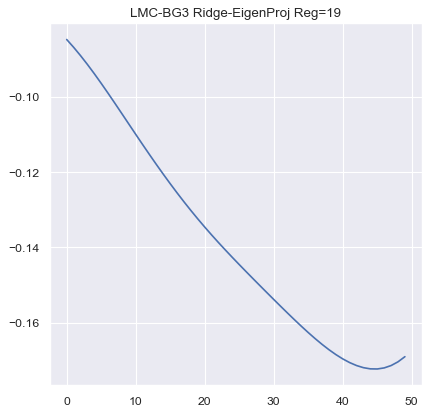

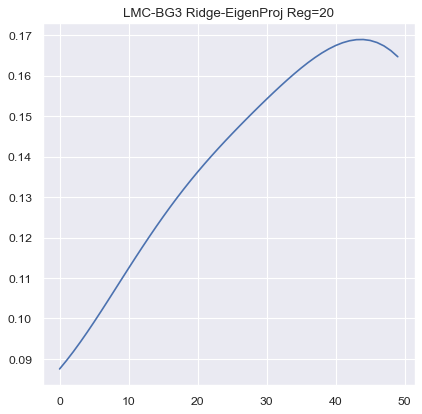

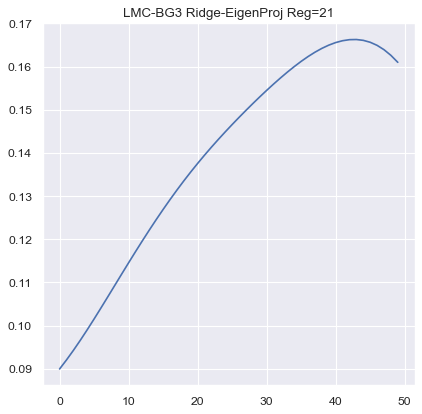

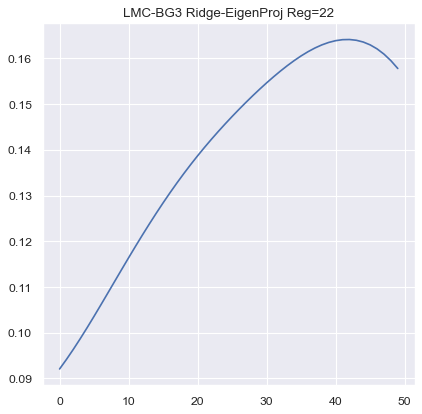

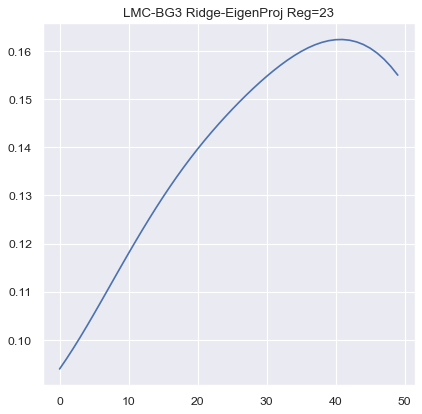

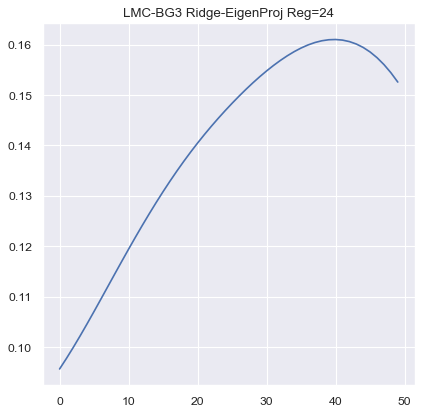

In [62]:
dim = 50
do_full_experiment('LMC-BG3', dim=dim, sig_scalar=1, plot_sig=True, plot_train=False, plot_test=True, plot_eigs=True)

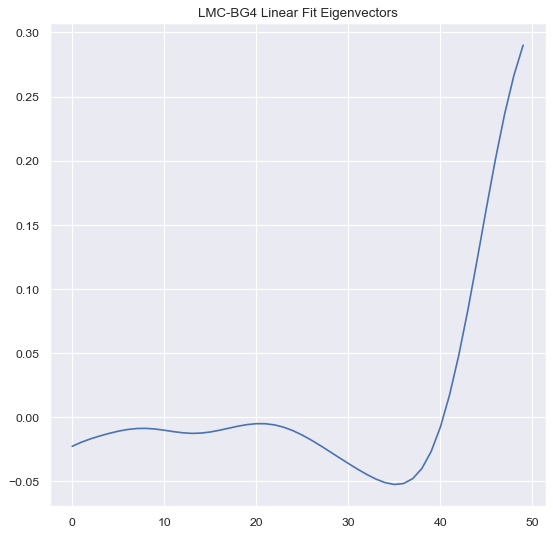

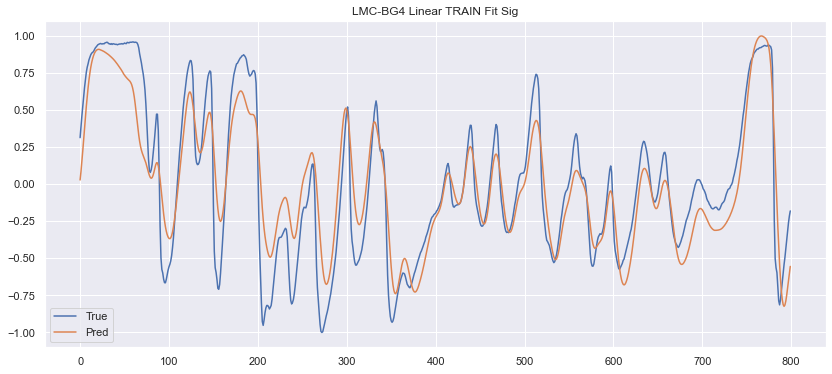

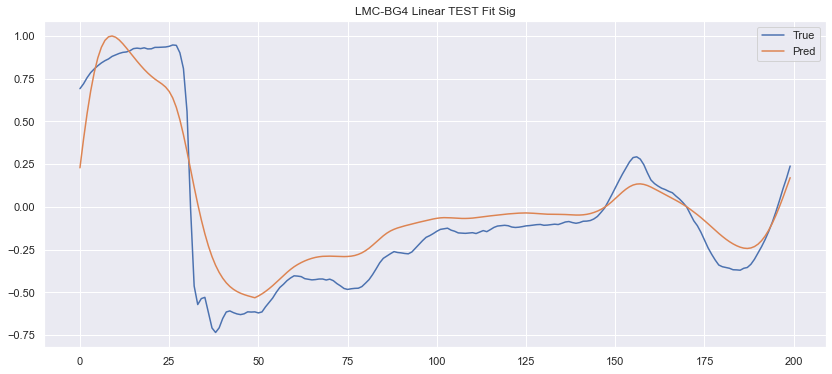

Train Error: 0.04934439680520711
Test Error: 0.024254660639588397


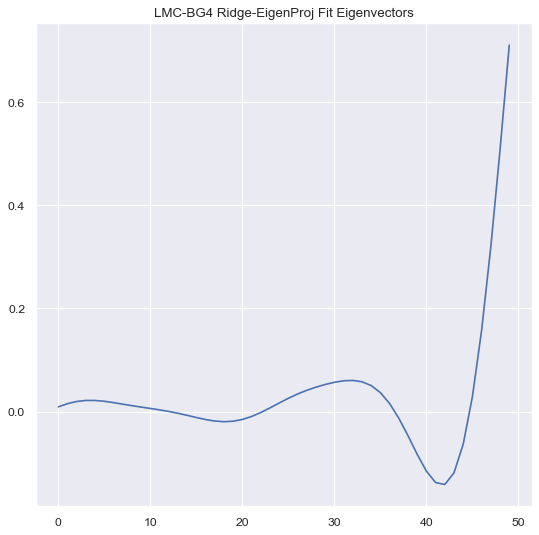

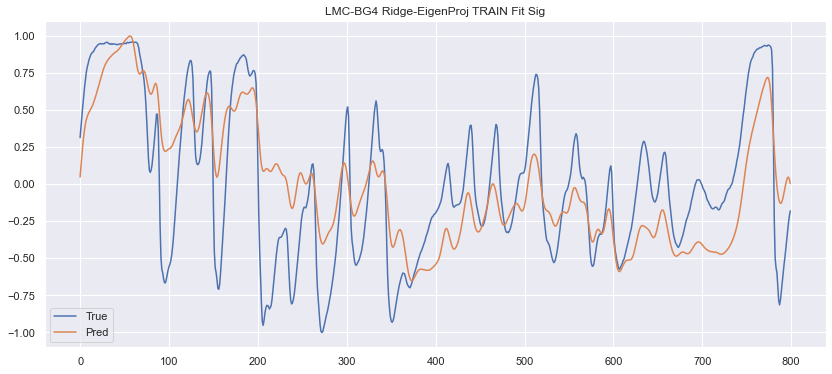

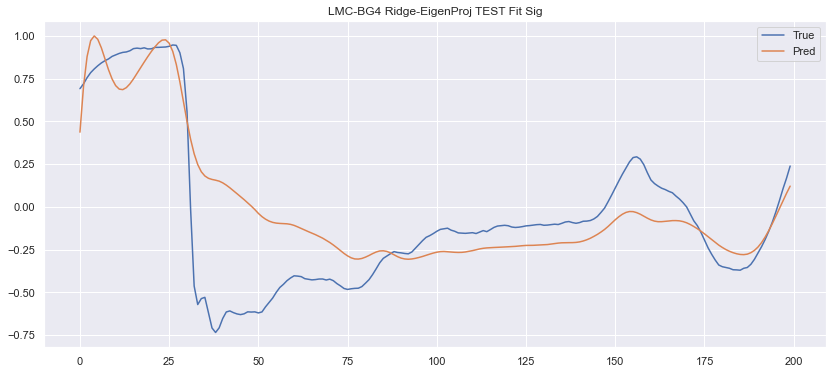

Train Error: 0.1282191613841046
Test Error: 0.07937957605178875


In [35]:
dim = 50
do_full_experiment('LMC-BG4', dim=dim,sig_scalar=-1, plot_train=False, plot_test=False)

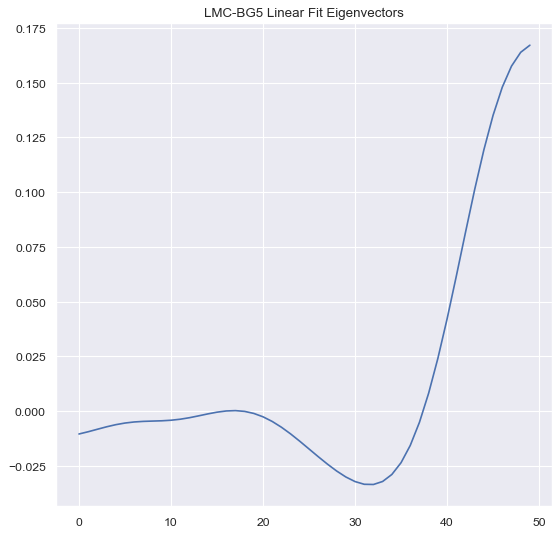

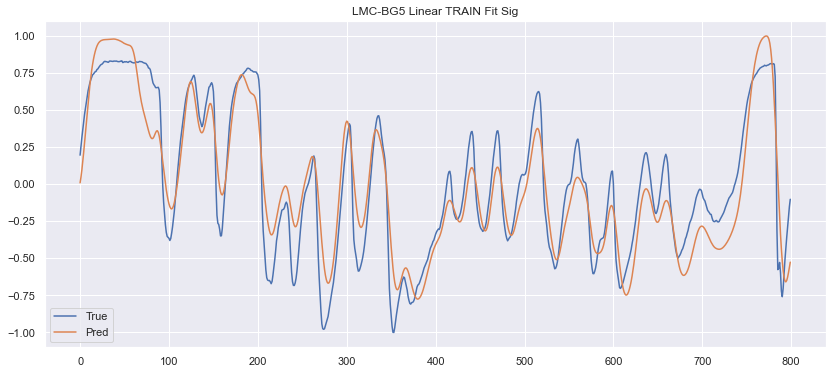

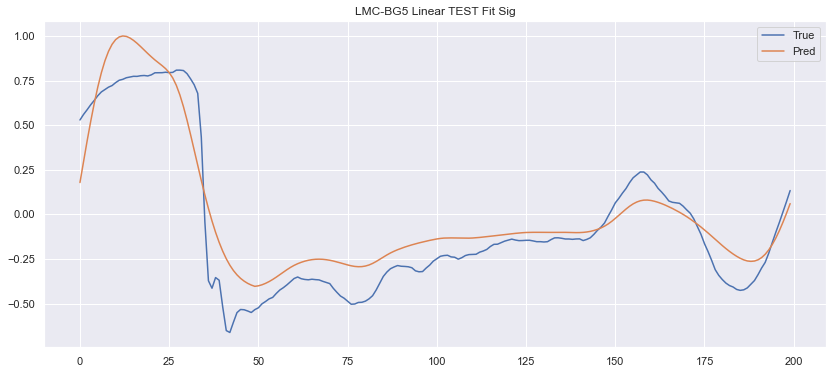

Train Error: 0.03719302322746279
Test Error: 0.021338437787212894


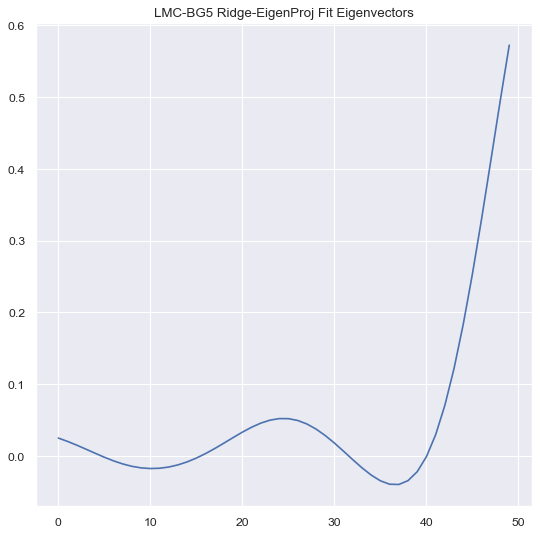

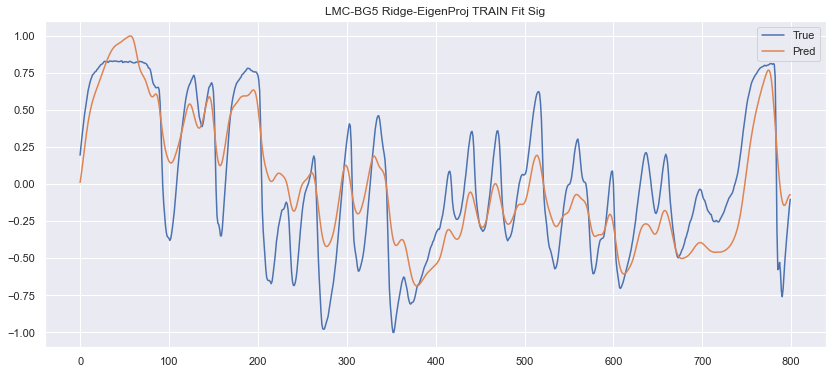

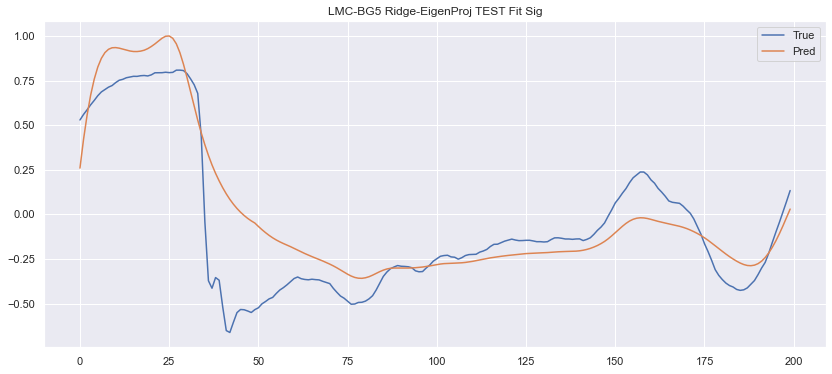

Train Error: 0.07107128965168495
Test Error: 0.0461030053927412


In [36]:
dim = 50
do_full_experiment('LMC-BG5', dim=dim, sig_scalar=-1, plot_train=False, plot_test=False)

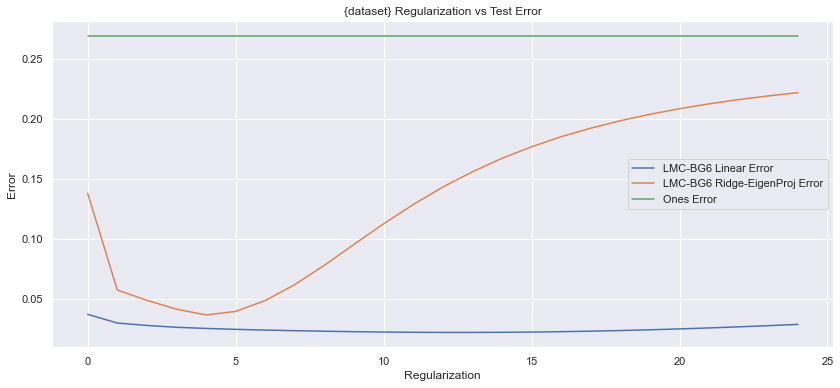

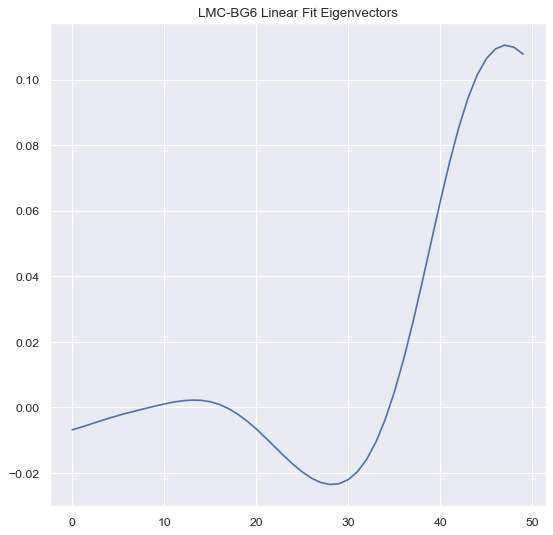

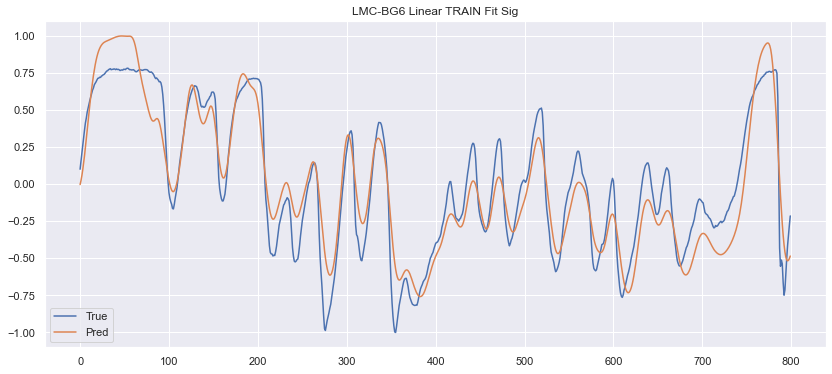

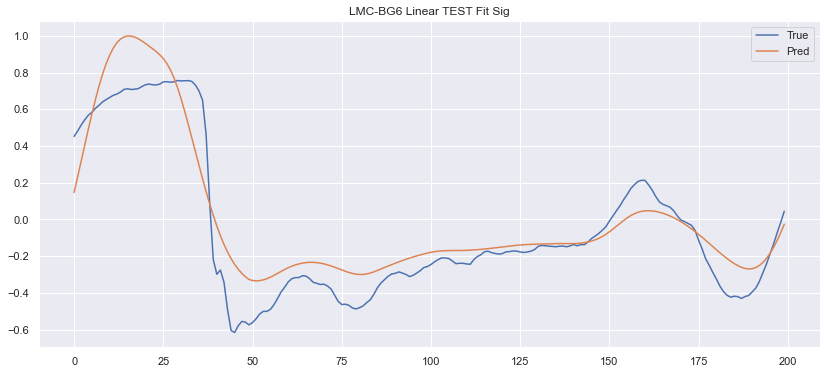

Train Error: 0.03077843739473206
Test Error: 0.022354427623735455


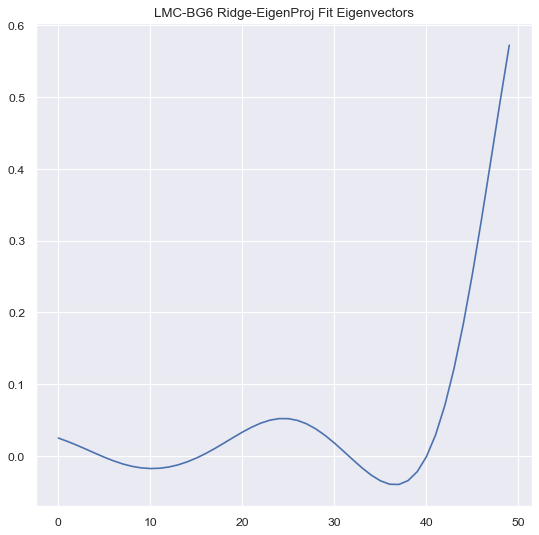

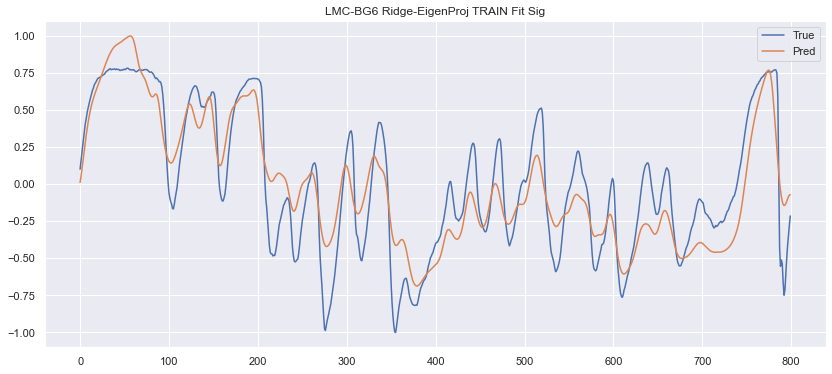

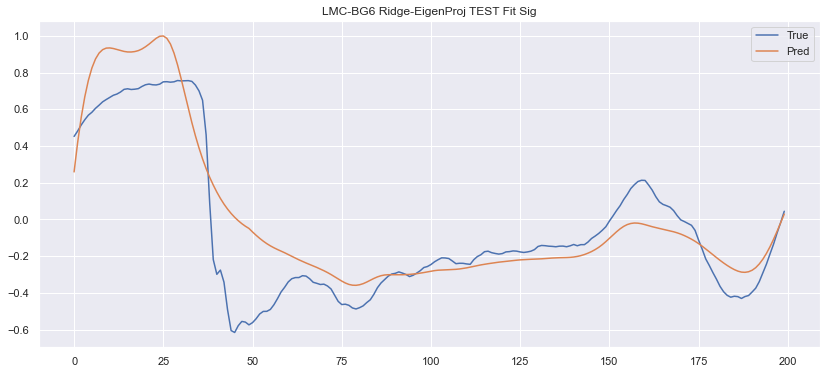

Train Error: 0.049590317353392796
Test Error: 0.03690105876016429


In [40]:
dim = 50
do_full_experiment('LMC-BG6', dim=dim, sig_scalar=-1,  plot_train=False, plot_test=True)

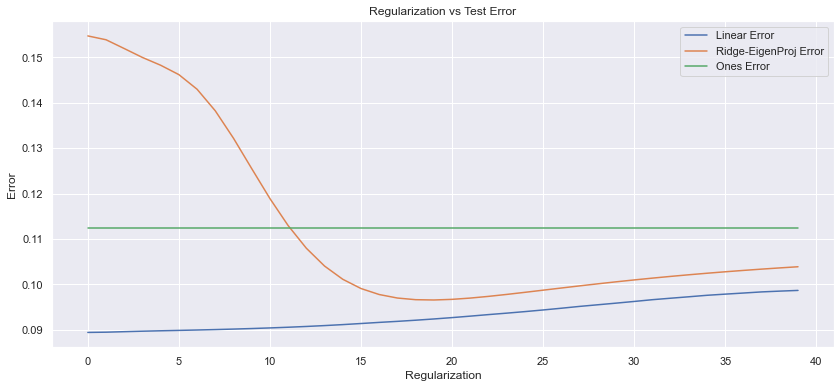

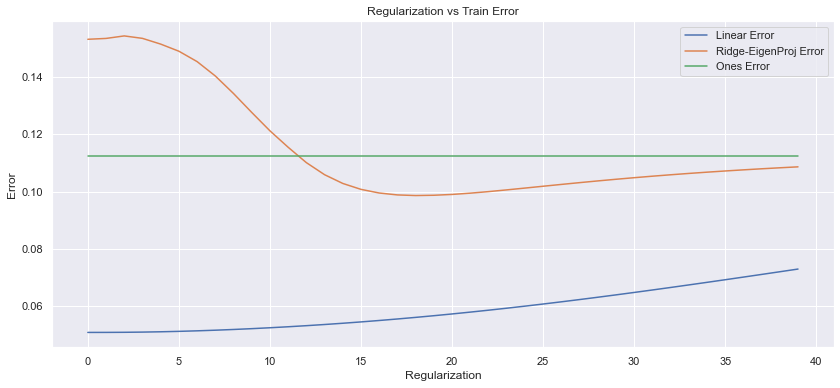

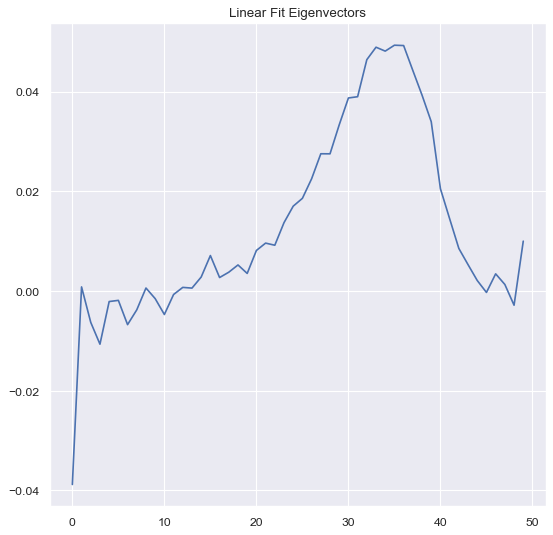

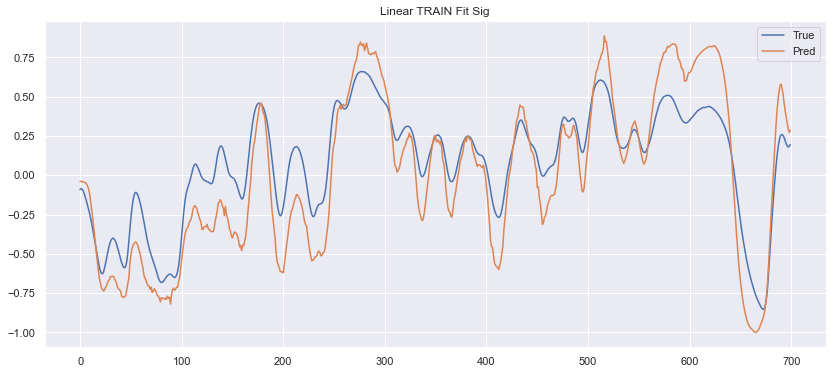

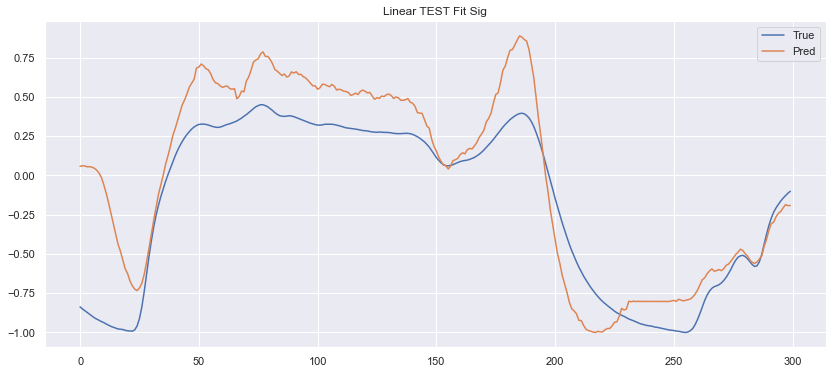

Train Error: 0.05085157283796958
Test Error: 0.08942487614779832


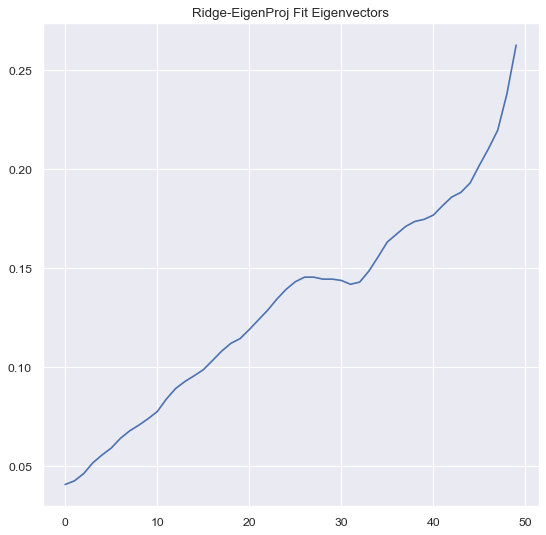

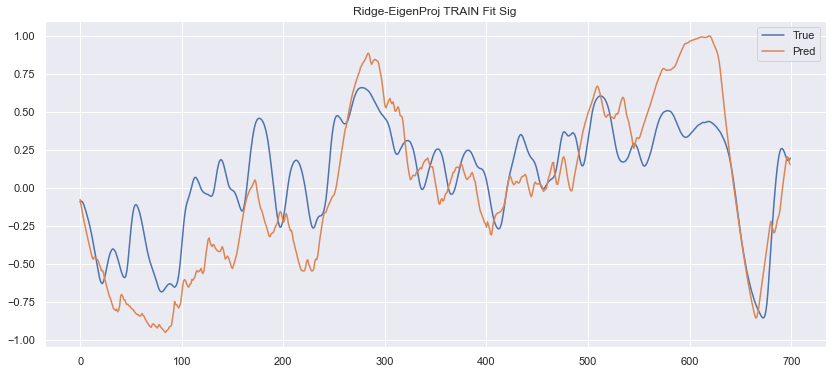

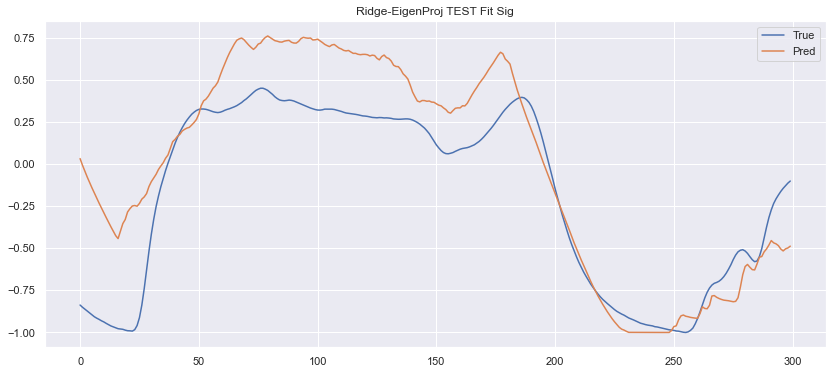

Train Error: 0.09873011804891613
Test Error: 0.09656977967824441


In [24]:
from tools import *
from projectors import *
dataset = 'PHOTO'
regs = np.arange(0,40,1)
dim = 50
train_test_ratio = 0.3
down = 10

ress, stims = read_lmc(dataset);
sig = normalize(np.mean(stims[:, ::down], axis=0)) 
res = normalize(np.mean(ress[:, ::down], axis=0)) 

# noise = 2
# sig += noise * np.random.randn(*sig.shape)

# baseline
ones_train_err, ones_test_err, _ = train_test_method(sig, res, ones_model, dim=dim, train_test_ratio=train_test_ratio, plot=False)

# run tests
all_results = [Results(linear_model, 'Linear'), Results(eigen_proj, 'Ridge-EigenProj') ]

for reg in regs:
    for results in all_results:
        r = train_test_method(sig, res, results.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=False)
        results.add_results(reg, r)


for result in all_results:
    plt.plot(regs, result.test_errs, label=f'{result.name} Error')

plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
plt.xlabel('Regularization'); plt.ylabel('Error');
plt.legend(); plt.title("Regularization vs Test Error"); plt.show();

for result in all_results:
    plt.plot(regs, result.train_errs, label=f'{result.name} Error')

plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
plt.xlabel('Regularization'); plt.ylabel('Error');
plt.legend(); plt.title("Regularization vs Train Error"); plt.show();

for result in all_results:
    reg, filt = result.get_test_opt()
    train_test_method(sig, res, result.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=True, name=result.name)
